Found 30 videos
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



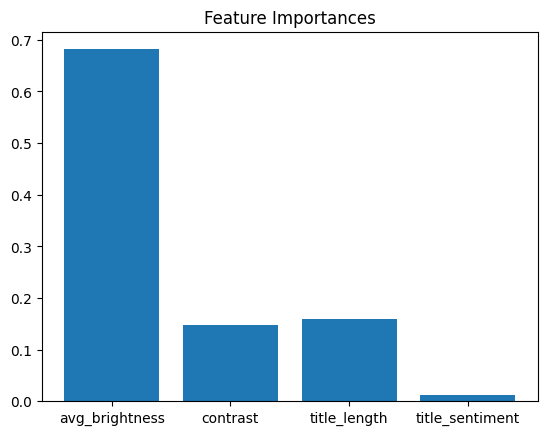

Misclassified Samples:
Empty DataFrame
Columns: [title, thumbnail_path, label]
Index: []
Dataset with features saved to youtube_thumbnails_features.csv


In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import os
import pandas as pd
import time
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob

channel_videos_url = "https://www.youtube.com/@alessyafarrugia/videos"
num_videos = 30  # adjust for larger dataset
output_folder = "thumbnails"
csv_file = "youtube_thumbnails_features.csv"

headers = {"User-Agent": "Mozilla/5.0"}
os.makedirs(output_folder, exist_ok=True)

response = requests.get(channel_videos_url, headers=headers)
html = response.text

video_ids = re.findall(r"\"videoId\":\"([^\"]+)\"", html)
video_titles = re.findall(r"\"title\":{\"runs\":\[{\s*\"text\":\"([^\"]+)\"\}\]", html)

video_ids = video_ids[:num_videos]
video_titles = video_titles[:num_videos]

print(f"Found {len(video_ids)} videos")

video_data = []


for idx, vid_id in enumerate(video_ids):
    video_url = f"https://www.youtube.com/watch?v={vid_id}"
    video_response = requests.get(video_url, headers=headers)
    video_html = video_response.text

    views_match = re.search(r'"viewCount":"(\d+)"', video_html)
    views = int(views_match.group(1)) if views_match else 0

    thumbnail_url = f"https://i.ytimg.com/vi/{vid_id}/hqdefault.jpg"
    img_path = f"{output_folder}/video_{idx}.jpg"

    try:
        img_data = requests.get(thumbnail_url).content
        with open(img_path, 'wb') as handler:
            handler.write(img_data)
    except:
        print(f"Failed to download thumbnail for video {vid_id}")

    video_data.append({
        "video_id": vid_id,
        "title": video_titles[idx] if idx < len(video_titles) else "Unknown",
        "thumbnail_path": img_path,
        "views": views
    })

    time.sleep(1)

views_list = [v['views'] for v in video_data]
threshold = sorted(views_list, reverse=True)[int(0.3*len(views_list))]

for v in video_data:
    v['label'] = 1 if v['views'] >= threshold else 0

def average_brightness(image_path):
    img = Image.open(image_path).convert('L')
    return np.array(img).mean()

def contrast(image_path):
    img = Image.open(image_path).convert('L')
    arr = np.array(img)
    return arr.std()

for v in video_data:
    v['avg_brightness'] = average_brightness(v['thumbnail_path'])
    v['contrast'] = contrast(v['thumbnail_path'])
    v['title_length'] = len(v['title'])
    v['title_sentiment'] = TextBlob(v['title']).sentiment.polarity

df = pd.DataFrame(video_data)
feature_cols = ['avg_brightness', 'contrast', 'title_length', 'title_sentiment']
X = df[feature_cols]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.bar(feature_cols, importances)
plt.title("Feature Importances")
plt.show()

misclassified = X_test[y_test != y_pred]
print("Misclassified Samples:")
print(df.loc[misclassified.index][['title', 'thumbnail_path', 'label']])

df.to_csv(csv_file, index=False)
print(f"Dataset with features saved to {csv_file}")